## AirQo Low-Cost Air Quality Monitor Calibration Challenge by DataFest Kampala

In [1]:
#load dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import statsmodels.api as sm

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
os.chdir('/content/drive/My Drive/AirQo Prediction')
!ls

'AirQo Challenge.ipynb'       cbr_prediction4.csv     xgbr_prediction2.csv
 airqo_SampleSubmission.csv   cbr_prediction5.csv     xgbr_prediction3.csv
 airqo_Test.csv		      cbr_prediction.csv      xgbr_prediction4.csv
 airqo_Train.csv	      mlp_prediction.csv      xgbr_prediction5.csv
 catboost_info		      rf_prediction2.csv      xgbr_prediction8.csv
 cbr_prediction2.csv	      rf_prediction.csv       xgbr_prediction9.csv
 cbr_prediction3.csv	      xgbr_prediction10.csv   xgbr_prediction.csv


In [4]:
# loading the data

try:
    train = pd.read_csv("airqo_Train.csv" , low_memory=False)
    test = pd.read_csv("airqo_Test.csv" , low_memory=False)
    ss = pd.read_csv("airqo_SampleSubmission.csv" , low_memory=False)
    
except:
    !colab_download
    train = pd.read_csv("airqo_Train.csv" , low_memory=False)
    test = pd.read_csv("airqo_Test.csv" , low_memory=False)
    ss = pd.read_csv("airqo_SampleSubmission.csv" , low_memory=False)
   

In [5]:
#check the data
train.head(5)

,ID,created_at,site,pm2_5,pm10,s2_pm2_5,s2_pm10,humidity,temp,lat,long,altitude,greenness,landform_90m,landform_270m,population,dist_major_road,ref_pm2_5
0,ID_0038MG0B,2020-04-23 17:00:00+03:00,USEmbassy,6.819048,7.313810,6.794048,7.838333,0.807417,22.383333,0.299255,32.592686,1199,4374,21,14,6834,130,25.0
1,ID_008ASVDD,2020-02-23 19:00:00+03:00,USEmbassy,57.456047,67.883488,55.643488,70.646977,0.712417,25.350000,0.299255,32.592686,1199,4374,21,14,6834,130,68.0
2,ID_009ACJQ9,2021-01-23 04:00:00+03:00,Nakawa,170.009773,191.153636,165.308636,191.471591,0.907833,20.616667,0.331740,32.609510,1191,5865,31,-11,4780,500,149.7
3,ID_00IGMAQ2,2019-12-04 09:00:00+03:00,USEmbassy,49.732821,61.512564,0.000000,0.000000,0.949667,21.216667,0.299255,32.592686,1199,4374,21,14,6834,130,54.0
4,ID_00P76VAQ,2019-10-01 01:00:00+03:00,USEmbassy,41.630455,51.044545,41.725000,51.141364,0.913833,18.908333,0.299255,32.592686,1199,4374,21,14,6834,130,39.0


In [6]:
train.shape

(10932, 18)

In [7]:
test.head(5)

,ID,created_at,site,pm2_5,pm10,s2_pm2_5,s2_pm10,humidity,temp,lat,long,altitude,greenness,landform_90m,landform_270m,population,dist_major_road
0,ID_00OZLF7X,2020-03-13 07:00:00+03:00,USEmbassy,31.900455,35.515455,31.672273,37.051818,0.927167,21.175000,0.299255,32.592686,1199,4374,21,14,6834,130
1,ID_00ZI0D98,2020-08-08 10:00:00+03:00,Makerere,53.581818,66.603636,50.586364,64.651818,0.811583,22.350000,0.333501,32.568561,1233,6340,21,28,8518,475
2,ID_017GTLAU,2020-08-25 09:00:00+03:00,Makerere,62.377500,71.647500,59.023333,69.766667,0.902000,20.766667,0.333501,32.568561,1233,6340,21,28,8518,475
3,ID_01IBM7T2,2020-06-15 16:00:00+03:00,USEmbassy,33.310294,36.958824,33.060882,38.674412,0.643417,25.483333,0.299255,32.592686,1199,4374,21,14,6834,130
4,ID_01II27D4,2021-01-13 00:00:00+03:00,Nakawa,64.782045,75.247500,64.638182,77.108864,0.939667,20.133333,0.331740,32.609510,1191,5865,31,-11,4780,500


In [8]:
test.shape

(2733, 17)

In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10932 entries, 0 to 10931
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               10932 non-null  object 
 1   created_at       10932 non-null  object 
 2   site             10932 non-null  object 
 3   pm2_5            10932 non-null  float64
 4   pm10             10932 non-null  float64
 5   s2_pm2_5         10932 non-null  float64
 6   s2_pm10          10932 non-null  float64
 7   humidity         10926 non-null  float64
 8   temp             10915 non-null  float64
 9   lat              10932 non-null  float64
 10  long             10932 non-null  float64
 11  altitude         10932 non-null  int64  
 12  greenness        10932 non-null  int64  
 13  landform_90m     10932 non-null  int64  
 14  landform_270m    10932 non-null  int64  
 15  population       10932 non-null  int64  
 16  dist_major_road  10932 non-null  int64  
 17  ref_pm2_5   

`created_at` not assigned the right data type and there are missing values in `humidity` and `temp`

In [10]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2733 entries, 0 to 2732
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               2733 non-null   object 
 1   created_at       2733 non-null   object 
 2   site             2733 non-null   object 
 3   pm2_5            2733 non-null   float64
 4   pm10             2733 non-null   float64
 5   s2_pm2_5         2733 non-null   float64
 6   s2_pm10          2733 non-null   float64
 7   humidity         2732 non-null   float64
 8   temp             2729 non-null   float64
 9   lat              2733 non-null   float64
 10  long             2733 non-null   float64
 11  altitude         2733 non-null   int64  
 12  greenness        2733 non-null   int64  
 13  landform_90m     2733 non-null   int64  
 14  landform_270m    2733 non-null   int64  
 15  population       2733 non-null   int64  
 16  dist_major_road  2733 non-null   int64  
dtypes: float64(8),

Also in the test data, `created_at` not in the appropriate data type and there are missing values in `temp` and `humidity`

## Merging the train and test sets

In [11]:
# join train and test together for easy preprocessing
num_train = train.shape[0]
num_test = test.shape[0]

data = pd.concat((train, test)).reset_index(drop=True)
print("data size is : {}".format(data.shape))

data size is : (13665, 18)


In [12]:
data.head(10)

,ID,created_at,site,pm2_5,pm10,s2_pm2_5,s2_pm10,humidity,temp,lat,long,altitude,greenness,landform_90m,landform_270m,population,dist_major_road,ref_pm2_5
0,ID_0038MG0B,2020-04-23 17:00:00+03:00,USEmbassy,6.819048,7.313810,6.794048,7.838333,0.807417,22.383333,0.299255,32.592686,1199,4374,21,14,6834,130,25.0
1,ID_008ASVDD,2020-02-23 19:00:00+03:00,USEmbassy,57.456047,67.883488,55.643488,70.646977,0.712417,25.350000,0.299255,32.592686,1199,4374,21,14,6834,130,68.0
2,ID_009ACJQ9,2021-01-23 04:00:00+03:00,Nakawa,170.009773,191.153636,165.308636,191.471591,0.907833,20.616667,0.331740,32.609510,1191,5865,31,-11,4780,500,149.7
3,ID_00IGMAQ2,2019-12-04 09:00:00+03:00,USEmbassy,49.732821,61.512564,0.000000,0.000000,0.949667,21.216667,0.299255,32.592686,1199,4374,21,14,6834,130,54.0
4,ID_00P76VAQ,2019-10-01 01:00:00+03:00,USEmbassy,41.630455,51.044545,41.725000,51.141364,0.913833,18.908333,0.299255,32.592686,1199,4374,21,14,6834,130,39.0
5,ID_00R7I3TR,2020-03-08 01:00:00+03:00,USEmbassy,31.032791,34.280000,31.184419,37.661395,0.877500,22.466667,0.299255,32.592686,1199,4374,21,14,6834,130,38.0
6,ID_00TPMZ3E,2020-01-26 12:00:00+03:00,USEmbassy,139.293721,143.999302,132.280930,144.528605,0.652500,21.616667,0.299255,32.592686,1199,4374,21,14,6834,130,117.0
7,ID_00ZYLEUU,2021-02-21 07:00:00+03:00,USEmbassy,130.772326,175.806512,123.275349,145.265349,0.810333,18.508333,0.299255,32.592686,1199,4374,21,14,6834,130,172.0
8,ID_011H25D3,2020-12-07 12:00:00+03:00,Makerere,36.585000,44.775000,34.550000,41.140000,0.814750,23.366667,0.333501,32.568561,1233,6340,21,28,8518,475,21.5
9,ID_01BLU6LY,2020-07-18 06:00:00+03:00,Makerere,30.236923,34.012308,29.026923,32.520000,0.737500,20.341667,0.333501,32.568561,1233,6340,21,28,8518,475,18.2


In [13]:
#merging the train and test data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13665 entries, 0 to 13664
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               13665 non-null  object 
 1   created_at       13665 non-null  object 
 2   site             13665 non-null  object 
 3   pm2_5            13665 non-null  float64
 4   pm10             13665 non-null  float64
 5   s2_pm2_5         13665 non-null  float64
 6   s2_pm10          13665 non-null  float64
 7   humidity         13658 non-null  float64
 8   temp             13644 non-null  float64
 9   lat              13665 non-null  float64
 10  long             13665 non-null  float64
 11  altitude         13665 non-null  int64  
 12  greenness        13665 non-null  int64  
 13  landform_90m     13665 non-null  int64  
 14  landform_270m    13665 non-null  int64  
 15  population       13665 non-null  int64  
 16  dist_major_road  13665 non-null  int64  
 17  ref_pm2_5   

the `created_at` column is not in the appropriate data type, we correct this

In [14]:
data['created_at'] = pd.to_datetime(data['created_at'])

In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13665 entries, 0 to 13664
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype                                
---  ------           --------------  -----                                
 0   ID               13665 non-null  object                               
 1   created_at       13665 non-null  datetime64[ns, pytz.FixedOffset(180)]
 2   site             13665 non-null  object                               
 3   pm2_5            13665 non-null  float64                              
 4   pm10             13665 non-null  float64                              
 5   s2_pm2_5         13665 non-null  float64                              
 6   s2_pm10          13665 non-null  float64                              
 7   humidity         13658 non-null  float64                              
 8   temp             13644 non-null  float64                              
 9   lat              13665 non-null  float64          

In [16]:
data.head()

,ID,created_at,site,pm2_5,pm10,s2_pm2_5,s2_pm10,humidity,temp,lat,long,altitude,greenness,landform_90m,landform_270m,population,dist_major_road,ref_pm2_5
0,ID_0038MG0B,2020-04-23 17:00:00+03:00,USEmbassy,6.819048,7.313810,6.794048,7.838333,0.807417,22.383333,0.299255,32.592686,1199,4374,21,14,6834,130,25.0
1,ID_008ASVDD,2020-02-23 19:00:00+03:00,USEmbassy,57.456047,67.883488,55.643488,70.646977,0.712417,25.350000,0.299255,32.592686,1199,4374,21,14,6834,130,68.0
2,ID_009ACJQ9,2021-01-23 04:00:00+03:00,Nakawa,170.009773,191.153636,165.308636,191.471591,0.907833,20.616667,0.331740,32.609510,1191,5865,31,-11,4780,500,149.7
3,ID_00IGMAQ2,2019-12-04 09:00:00+03:00,USEmbassy,49.732821,61.512564,0.000000,0.000000,0.949667,21.216667,0.299255,32.592686,1199,4374,21,14,6834,130,54.0
4,ID_00P76VAQ,2019-10-01 01:00:00+03:00,USEmbassy,41.630455,51.044545,41.725000,51.141364,0.913833,18.908333,0.299255,32.592686,1199,4374,21,14,6834,130,39.0


In [17]:
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
pm2_5,13665.0,51.657810,34.920267,0.567273,29.096000,43.749231,63.949535,335.433023
pm10,13665.0,59.899393,38.520368,0.595909,33.333864,54.436000,74.957619,407.713953
s2_pm2_5,13665.0,48.323712,34.627287,0.000000,26.298182,42.238889,61.153023,330.275152
s2_pm10,13665.0,56.905575,39.269151,0.000000,29.895714,52.658333,73.337674,384.627045
humidity,13658.0,0.824645,0.134754,0.307167,0.735438,0.857250,0.933167,1.000000
temp,13644.0,21.969816,2.798616,16.175000,19.783333,21.366667,24.025000,30.781818
lat,13665.0,0.314090,0.016703,0.299255,0.299255,0.299255,0.333501,0.333501
long,13665.0,32.588471,0.013861,32.568561,32.568561,32.592686,32.592686,32.609510
altitude,13665.0,1207.407464,16.369318,1191.000000,1199.000000,1199.000000,1233.000000,1233.000000
greenness,13665.0,5166.947677,904.989993,4374.000000,4374.000000,4374.000000,6340.000000,6340.000000


## Correlational Analysis before feature engineering

In [18]:
corr_matrix = data.corr()
print(corr_matrix["ref_pm2_5"].sort_values(ascending=False))

ref_pm2_5          1.000000
pm10               0.829827
pm2_5              0.821103
s2_pm2_5           0.755162
s2_pm10            0.752732
long               0.176348
humidity           0.030603
landform_90m      -0.035147
landform_270m     -0.098641
temp              -0.109582
population        -0.132610
altitude          -0.222725
dist_major_road   -0.243103
lat               -0.250891
greenness         -0.260556
Name: ref_pm2_5, dtype: float64


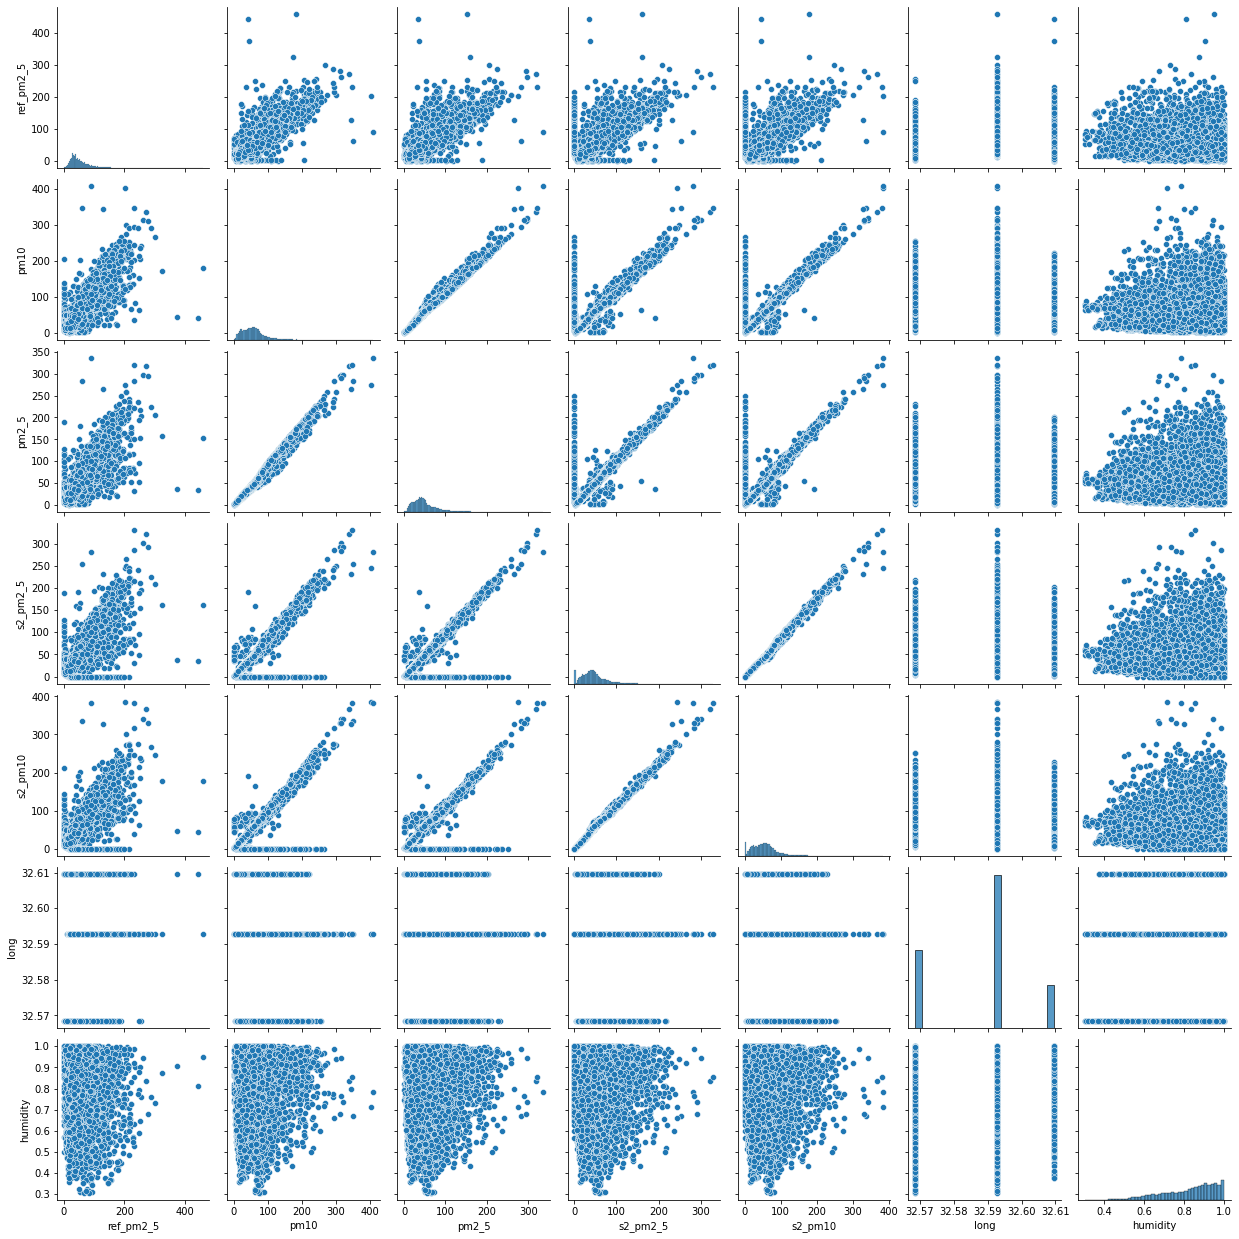

In [19]:
data_plot1 = data[['ref_pm2_5','pm10','pm2_5','s2_pm2_5','s2_pm10','long','humidity']]

sns.pairplot(data_plot1, kind="scatter")
plt.show()

Columns `pm10`,`pm2_5`,`s2_pm2_5` and `s2_pm10` have strong linear relationship with the categorical varable, and these variables are as well strongly related with themselves while `long` is a categorical variable.

### Check for multicollinearity

In [20]:
 data[['pm10','pm2_5','s2_pm2_5','s2_pm10']].corr()

,pm10,pm2_5,s2_pm2_5,s2_pm10
pm10,1.000000,0.991788,0.915584,0.916116
pm2_5,0.991788,1.000000,0.918739,0.912683
s2_pm2_5,0.915584,0.918739,1.000000,0.996192
s2_pm10,0.916116,0.912683,0.996192,1.000000


The above correlation statistics reveals that these variables are near perfect correlation, most especially `s2_pm10` and `s2_pm2_5`

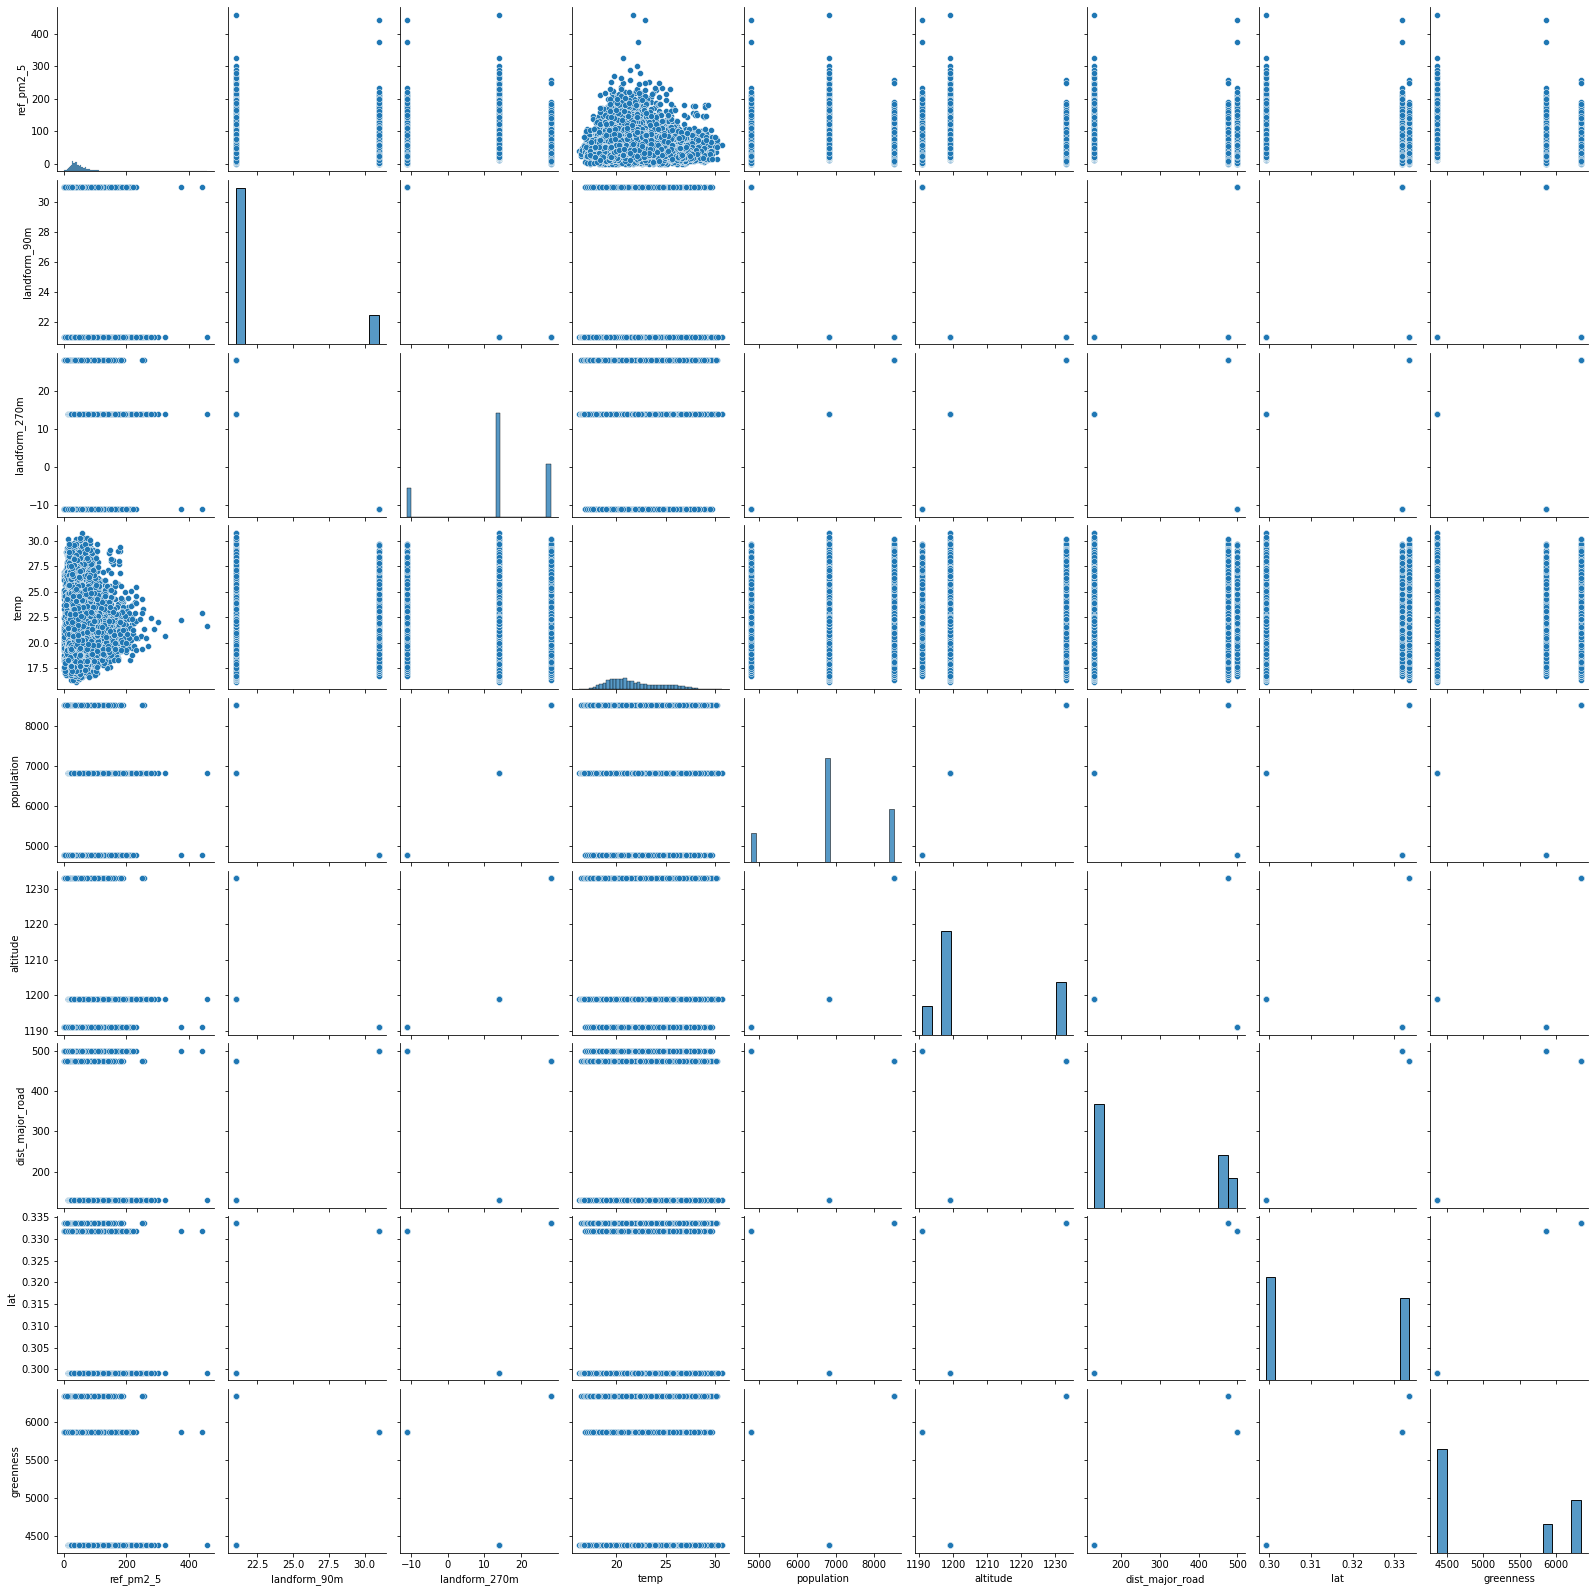

In [21]:
data_plot2 = data[['ref_pm2_5','landform_90m','landform_270m','temp','population','altitude','dist_major_road','lat','greenness']]

sns.pairplot(data_plot2, kind="scatter")
plt.show()

Except for variable `temp`, all the columns in `data_plot2` are categorical

Dealing with missing values in `humidity` and `temp` columns

In [22]:
data[data.isnull().any(axis=1)]

,ID,created_at,site,pm2_5,pm10,s2_pm2_5,s2_pm10,humidity,temp,lat,long,altitude,greenness,landform_90m,landform_270m,population,dist_major_road,ref_pm2_5
107,ID_0CGNFFKM,2019-12-11 15:00:00+03:00,USEmbassy,8.957111,10.056222,0.000000,0.000000,0.698333,NaN,0.299255,32.592686,1199,4374,21,14,6834,130,29.0
217,ID_0PIX15JU,2021-01-29 16:00:00+03:00,USEmbassy,28.912727,42.107727,32.221818,38.336818,NaN,23.008333,0.299255,32.592686,1199,4374,21,14,6834,130,40.0
866,ID_2SJK2ZE8,2019-12-11 16:00:00+03:00,USEmbassy,11.686739,13.390652,0.000000,0.000000,0.720000,NaN,0.299255,32.592686,1199,4374,21,14,6834,130,27.0
1111,ID_3K5G7YQ7,2019-12-11 12:00:00+03:00,USEmbassy,26.937333,31.112667,0.000000,0.000000,0.761667,NaN,0.299255,32.592686,1199,4374,21,14,6834,130,37.0
1491,ID_4TQDTWR4,2020-02-25 14:00:00+03:00,USEmbassy,44.975946,52.540541,43.596486,53.765946,NaN,21.566667,0.299255,32.592686,1199,4374,21,14,6834,130,50.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13660,ID_ZW5RSNUS,2021-02-18 03:00:00+03:00,Makerere,43.508889,53.786667,42.747778,53.457778,0.924833,22.358333,0.333501,32.568561,1233,6340,21,28,8518,475,NaN
13661,ID_ZWCI817N,2021-01-21 23:00:00+03:00,Nakawa,101.348049,114.076098,99.469512,116.441220,0.936333,20.500000,0.331740,32.609510,1191,5865,31,-11,4780,500,NaN
13662,ID_ZX5858FJ,2020-12-12 21:00:00+03:00,Makerere,47.248182,59.862727,46.526364,59.971818,0.857917,20.966667,0.333501,32.568561,1233,6340,21,28,8518,475,NaN
13663,ID_ZY4XOL2H,2021-02-08 02:00:00+03:00,USEmbassy,217.070465,264.880698,220.803488,249.663953,0.716833,22.158333,0.299255,32.592686,1199,4374,21,14,6834,130,NaN


In [23]:
data[data['humidity'].isnull()]

,ID,created_at,site,pm2_5,pm10,s2_pm2_5,s2_pm10,humidity,temp,lat,long,altitude,greenness,landform_90m,landform_270m,population,dist_major_road,ref_pm2_5
217,ID_0PIX15JU,2021-01-29 16:00:00+03:00,USEmbassy,28.912727,42.107727,32.221818,38.336818,NaN,23.008333,0.299255,32.592686,1199,4374,21,14,6834,130,40.0
1491,ID_4TQDTWR4,2020-02-25 14:00:00+03:00,USEmbassy,44.975946,52.540541,43.596486,53.765946,NaN,21.566667,0.299255,32.592686,1199,4374,21,14,6834,130,50.0
2130,ID_6X663HVJ,2020-11-10 16:00:00+03:00,Nakawa,26.381190,30.775952,26.815238,32.159524,NaN,22.566667,0.331740,32.609510,1191,5865,31,-11,4780,500,0.8
4774,ID_FQ9RFF8Z,2021-01-29 16:00:00+03:00,Makerere,23.030769,27.290000,21.069231,25.729231,NaN,23.008333,0.333501,32.568561,1233,6340,21,28,8518,475,21.5
6255,ID_KOAWVZ26,2019-12-20 15:00:00+03:00,USEmbassy,25.629429,27.330571,24.512857,28.176857,NaN,NaN,0.299255,32.592686,1199,4374,21,14,6834,130,46.0
8358,ID_RDMC3R2V,2019-12-20 13:00:00+03:00,USEmbassy,22.913462,23.791923,21.974231,24.215769,NaN,NaN,0.299255,32.592686,1199,4374,21,14,6834,130,38.0
13036,ID_S89ZTL8Z,2021-01-29 16:00:00+03:00,Nakawa,27.604545,34.014091,26.737045,34.265682,NaN,23.008333,0.331740,32.609510,1191,5865,31,-11,4780,500,NaN


In [24]:
data[data['temp'].isnull()]

,ID,created_at,site,pm2_5,pm10,s2_pm2_5,s2_pm10,humidity,temp,lat,long,altitude,greenness,landform_90m,landform_270m,population,dist_major_road,ref_pm2_5
107,ID_0CGNFFKM,2019-12-11 15:00:00+03:00,USEmbassy,8.957111,10.056222,0.000000,0.000000,0.698333,NaN,0.299255,32.592686,1199,4374,21,14,6834,130,29.0
866,ID_2SJK2ZE8,2019-12-11 16:00:00+03:00,USEmbassy,11.686739,13.390652,0.000000,0.000000,0.720000,NaN,0.299255,32.592686,1199,4374,21,14,6834,130,27.0
1111,ID_3K5G7YQ7,2019-12-11 12:00:00+03:00,USEmbassy,26.937333,31.112667,0.000000,0.000000,0.761667,NaN,0.299255,32.592686,1199,4374,21,14,6834,130,37.0
2610,ID_8KQUN3YJ,2019-12-11 09:00:00+03:00,USEmbassy,38.416667,47.073333,0.000000,0.000000,0.970000,NaN,0.299255,32.592686,1199,4374,21,14,6834,130,45.0
4085,ID_DHDL4P8J,2019-12-11 11:00:00+03:00,USEmbassy,29.901111,34.643556,0.000000,0.000000,0.780000,NaN,0.299255,32.592686,1199,4374,21,14,6834,130,41.0
4716,ID_FJG3JCVL,2019-12-11 00:00:00+03:00,USEmbassy,43.462955,55.111818,0.000000,0.000000,0.969167,NaN,0.299255,32.592686,1199,4374,21,14,6834,130,49.0
5764,ID_J199NQ3A,2019-12-11 06:00:00+03:00,USEmbassy,19.427273,22.002045,0.000000,0.000000,1.000000,NaN,0.299255,32.592686,1199,4374,21,14,6834,130,30.0
5829,ID_J88HLI63,2019-12-11 17:00:00+03:00,USEmbassy,12.506000,14.406222,0.000000,0.000000,0.753333,NaN,0.299255,32.592686,1199,4374,21,14,6834,130,27.0
5931,ID_JK7BXV2R,2019-12-11 10:00:00+03:00,USEmbassy,39.230000,48.211739,0.000000,0.000000,0.857500,NaN,0.299255,32.592686,1199,4374,21,14,6834,130,49.0
6255,ID_KOAWVZ26,2019-12-20 15:00:00+03:00,USEmbassy,25.629429,27.330571,24.512857,28.176857,NaN,NaN,0.299255,32.592686,1199,4374,21,14,6834,130,46.0


In [25]:
data['humidity'] = data['humidity'].fillna(np.mean(data.humidity))
data['temp'] = data['temp'].fillna(np.mean(data.temp))

In [26]:
data.isnull().sum()

ID                    0
created_at            0
site                  0
pm2_5                 0
pm10                  0
s2_pm2_5              0
s2_pm10               0
humidity              0
temp                  0
lat                   0
long                  0
altitude              0
greenness             0
landform_90m          0
landform_270m         0
population            0
dist_major_road       0
ref_pm2_5          2733
dtype: int64

In [27]:
# Extract date features
col = ['created_at']
def extract_date_info(data,col):
    for feat in col:
        data[feat +'_year'] = data[feat].dt.quarter
        data[feat +'_day'] = data[feat].dt.day
        data[feat +'_month'] = data[feat].dt.month
        data[feat +'_quarter'] = data[feat].dt.quarter
        data[feat +'_weekday'] = data[feat].dt.weekday
        data[feat +'_week'] = data[feat].dt.week
        data[feat +'_hour'] = data[feat].dt.hour
    #data.drop(columns=col,axis=1,inplace=True)

extract_date_info(data,col)

In [28]:
data.head(5)

,ID,created_at,site,pm2_5,pm10,s2_pm2_5,s2_pm10,humidity,temp,lat,long,altitude,greenness,landform_90m,landform_270m,population,dist_major_road,ref_pm2_5,created_at_year,created_at_day,created_at_month,created_at_quarter,created_at_weekday,created_at_week,created_at_hour
0,ID_0038MG0B,2020-04-23 17:00:00+03:00,USEmbassy,6.819048,7.313810,6.794048,7.838333,0.807417,22.383333,0.299255,32.592686,1199,4374,21,14,6834,130,25.0,2,23,4,2,3,17,17
1,ID_008ASVDD,2020-02-23 19:00:00+03:00,USEmbassy,57.456047,67.883488,55.643488,70.646977,0.712417,25.350000,0.299255,32.592686,1199,4374,21,14,6834,130,68.0,1,23,2,1,6,8,19
2,ID_009ACJQ9,2021-01-23 04:00:00+03:00,Nakawa,170.009773,191.153636,165.308636,191.471591,0.907833,20.616667,0.331740,32.609510,1191,5865,31,-11,4780,500,149.7,1,23,1,1,5,3,4
3,ID_00IGMAQ2,2019-12-04 09:00:00+03:00,USEmbassy,49.732821,61.512564,0.000000,0.000000,0.949667,21.216667,0.299255,32.592686,1199,4374,21,14,6834,130,54.0,4,4,12,4,2,49,9
4,ID_00P76VAQ,2019-10-01 01:00:00+03:00,USEmbassy,41.630455,51.044545,41.725000,51.141364,0.913833,18.908333,0.299255,32.592686,1199,4374,21,14,6834,130,39.0,4,1,10,4,1,40,1


In [29]:
data.drop(columns=['ID','created_at'],inplace=True)
data

,site,pm2_5,pm10,s2_pm2_5,s2_pm10,humidity,temp,lat,long,altitude,greenness,landform_90m,landform_270m,population,dist_major_road,ref_pm2_5,created_at_year,created_at_day,created_at_month,created_at_quarter,created_at_weekday,created_at_week,created_at_hour
0,USEmbassy,6.819048,7.313810,6.794048,7.838333,0.807417,22.383333,0.299255,32.592686,1199,4374,21,14,6834,130,25.0,2,23,4,2,3,17,17
1,USEmbassy,57.456047,67.883488,55.643488,70.646977,0.712417,25.350000,0.299255,32.592686,1199,4374,21,14,6834,130,68.0,1,23,2,1,6,8,19
2,Nakawa,170.009773,191.153636,165.308636,191.471591,0.907833,20.616667,0.331740,32.609510,1191,5865,31,-11,4780,500,149.7,1,23,1,1,5,3,4
3,USEmbassy,49.732821,61.512564,0.000000,0.000000,0.949667,21.216667,0.299255,32.592686,1199,4374,21,14,6834,130,54.0,4,4,12,4,2,49,9
4,USEmbassy,41.630455,51.044545,41.725000,51.141364,0.913833,18.908333,0.299255,32.592686,1199,4374,21,14,6834,130,39.0,4,1,10,4,1,40,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13660,Makerere,43.508889,53.786667,42.747778,53.457778,0.924833,22.358333,0.333501,32.568561,1233,6340,21,28,8518,475,NaN,1,18,2,1,3,7,3
13661,Nakawa,101.348049,114.076098,99.469512,116.441220,0.936333,20.500000,0.331740,32.609510,1191,5865,31,-11,4780,500,NaN,1,21,1,1,3,3,23
13662,Makerere,47.248182,59.862727,46.526364,59.971818,0.857917,20.966667,0.333501,32.568561,1233,6340,21,28,8518,475,NaN,4,12,12,4,5,50,21
13663,USEmbassy,217.070465,264.880698,220.803488,249.663953,0.716833,22.158333,0.299255,32.592686,1199,4374,21,14,6834,130,NaN,1,8,2,1,0,6,2


In [30]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13665 entries, 0 to 13664
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   site                13665 non-null  object 
 1   pm2_5               13665 non-null  float64
 2   pm10                13665 non-null  float64
 3   s2_pm2_5            13665 non-null  float64
 4   s2_pm10             13665 non-null  float64
 5   humidity            13665 non-null  float64
 6   temp                13665 non-null  float64
 7   lat                 13665 non-null  float64
 8   long                13665 non-null  float64
 9   altitude            13665 non-null  int64  
 10  greenness           13665 non-null  int64  
 11  landform_90m        13665 non-null  int64  
 12  landform_270m       13665 non-null  int64  
 13  population          13665 non-null  int64  
 14  dist_major_road     13665 non-null  int64  
 15  ref_pm2_5           10932 non-null  float64
 16  crea

In [31]:
data.site.unique()

array(['USEmbassy', 'Nakawa', 'Makerere'], dtype=object)

In [32]:
from sklearn.preprocessing import LabelEncoder
le =LabelEncoder()
data['site']=le.fit_transform(data['site'])

In [33]:
data.head()

,site,pm2_5,pm10,s2_pm2_5,s2_pm10,humidity,temp,lat,long,altitude,greenness,landform_90m,landform_270m,population,dist_major_road,ref_pm2_5,created_at_year,created_at_day,created_at_month,created_at_quarter,created_at_weekday,created_at_week,created_at_hour
0,2,6.819048,7.313810,6.794048,7.838333,0.807417,22.383333,0.299255,32.592686,1199,4374,21,14,6834,130,25.0,2,23,4,2,3,17,17
1,2,57.456047,67.883488,55.643488,70.646977,0.712417,25.350000,0.299255,32.592686,1199,4374,21,14,6834,130,68.0,1,23,2,1,6,8,19
2,1,170.009773,191.153636,165.308636,191.471591,0.907833,20.616667,0.331740,32.609510,1191,5865,31,-11,4780,500,149.7,1,23,1,1,5,3,4
3,2,49.732821,61.512564,0.000000,0.000000,0.949667,21.216667,0.299255,32.592686,1199,4374,21,14,6834,130,54.0,4,4,12,4,2,49,9
4,2,41.630455,51.044545,41.725000,51.141364,0.913833,18.908333,0.299255,32.592686,1199,4374,21,14,6834,130,39.0,4,1,10,4,1,40,1


In [34]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
site,13665.0,1.274497,0.876164,0.000000,0.000000,2.000000,2.000000,2.000000
pm2_5,13665.0,51.657810,34.920267,0.567273,29.096000,43.749231,63.949535,335.433023
pm10,13665.0,59.899393,38.520368,0.595909,33.333864,54.436000,74.957619,407.713953
s2_pm2_5,13665.0,48.323712,34.627287,0.000000,26.298182,42.238889,61.153023,330.275152
s2_pm10,13665.0,56.905575,39.269151,0.000000,29.895714,52.658333,73.337674,384.627045
humidity,13665.0,0.824645,0.134719,0.307167,0.735500,0.857167,0.933167,1.000000
temp,13665.0,21.969816,2.796465,16.175000,19.783333,21.366667,24.025000,30.781818
lat,13665.0,0.314090,0.016703,0.299255,0.299255,0.299255,0.333501,0.333501
long,13665.0,32.588471,0.013861,32.568561,32.568561,32.592686,32.592686,32.609510
altitude,13665.0,1207.407464,16.369318,1191.000000,1199.000000,1199.000000,1233.000000,1233.000000


The mean of `temp` and `humidity` does not change after feature engineering

## Correlational Analysis after Feature Engineering

In [35]:
#data[data.columns[:]].corr()['ref_pm2_5'][:]

In [36]:
data.corrwith(data['ref_pm2_5']).sort_values(ascending=False)

ref_pm2_5             1.000000
pm10                  0.829827
pm2_5                 0.821103
s2_pm2_5              0.755162
s2_pm10               0.752732
site                  0.266241
long                  0.176348
created_at_hour       0.092069
humidity              0.030599
created_at_day        0.018598
created_at_weekday   -0.016898
landform_90m         -0.035147
landform_270m        -0.098641
temp                 -0.109564
population           -0.132610
created_at_month     -0.158169
created_at_year      -0.171888
created_at_quarter   -0.171888
created_at_week      -0.181289
altitude             -0.222725
dist_major_road      -0.243103
lat                  -0.250891
greenness            -0.260556
dtype: float64

A negligible change (increase) is observed in the correlation between the target variable variables `temp` and `humidity` after the feature engineering

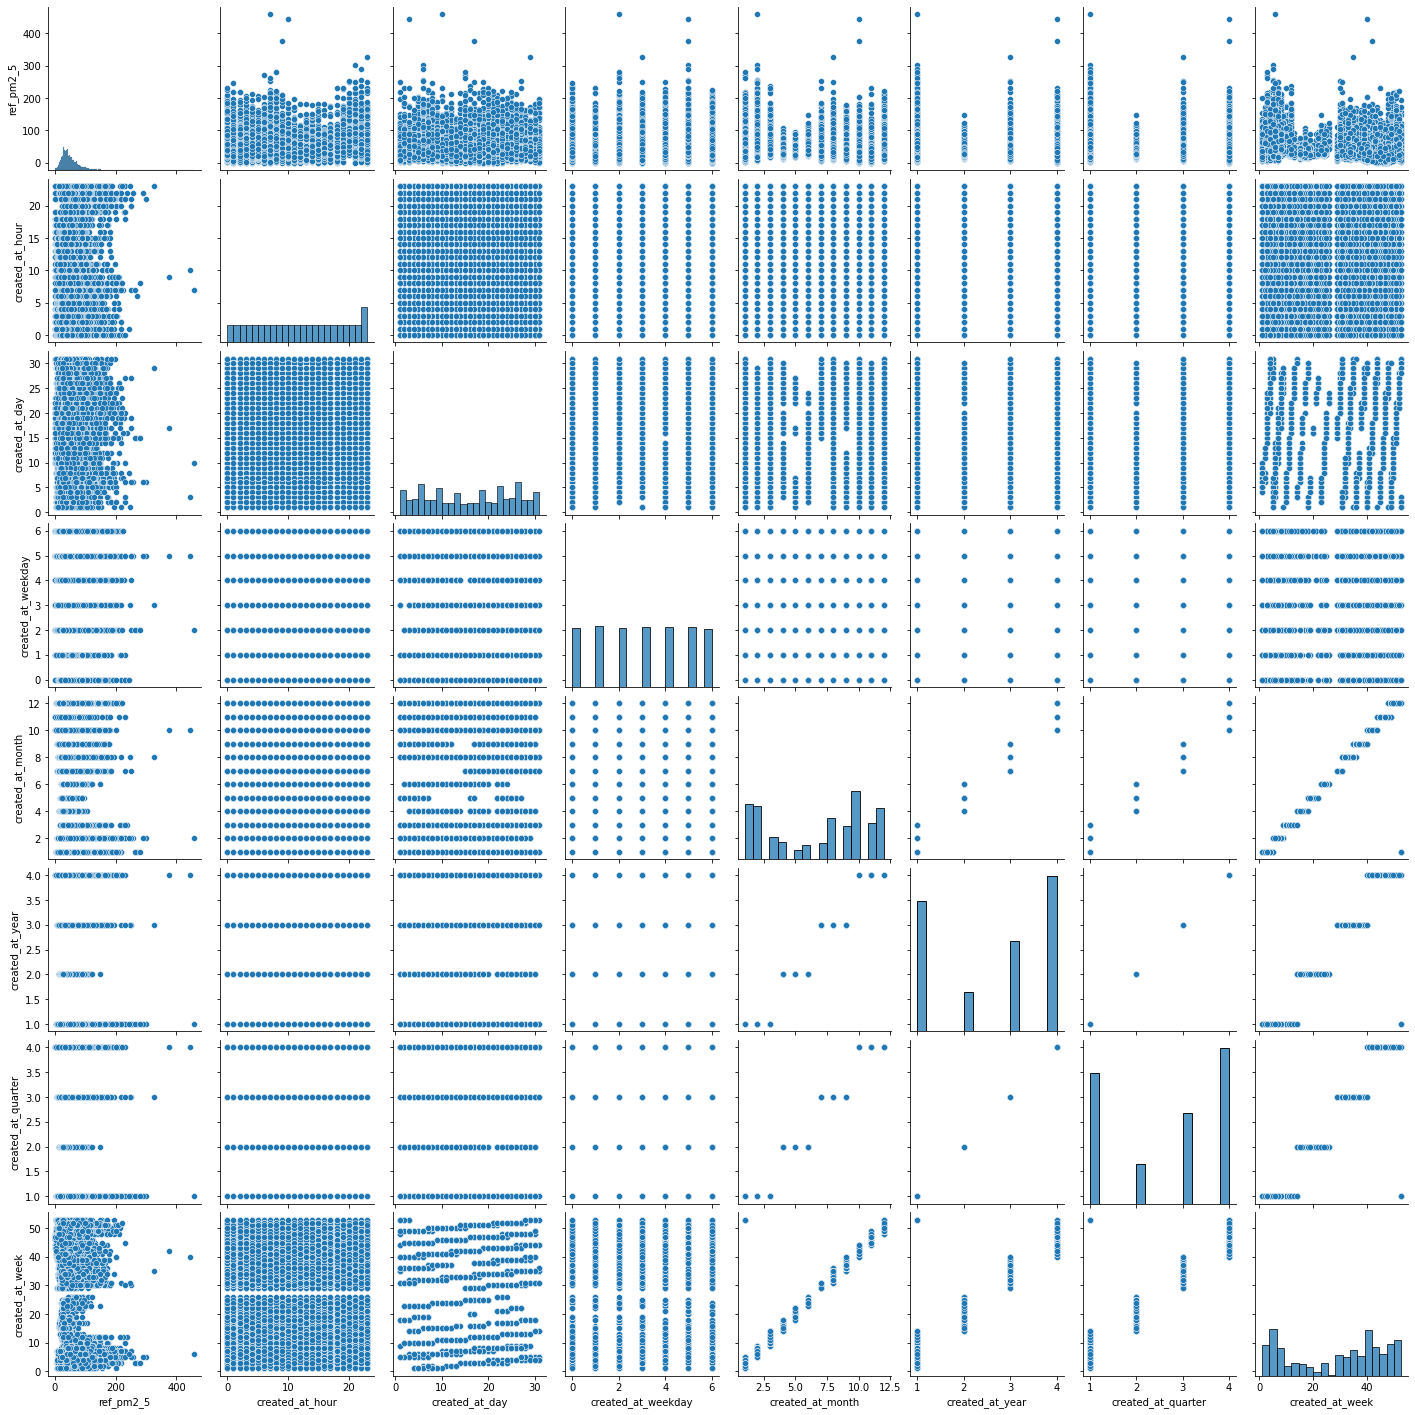

In [37]:
data_plot3 = data[['ref_pm2_5','created_at_hour','created_at_day','created_at_weekday','created_at_month','created_at_year','created_at_quarter','created_at_week']]

sns.pairplot(data_plot3, kind="scatter")
plt.show()

The above plot shows there are no linear relationship between the target variables and the features extracted (engineered) from the `created_at` column. They are exhibited to be mostly categorical.

## Splitting the Dataset

In [38]:
##

In [640]:
#Get the new dataset
train_new = data[:num_train]
test_new = data[num_train:]

In [641]:
test_new.drop("ref_pm2_5",axis = 1,inplace = True)#dropping the target column in the test dataset

In [642]:
test_new.head()

,site,pm2_5,pm10,s2_pm2_5,s2_pm10,humidity,temp,lat,long,altitude,greenness,landform_90m,landform_270m,population,dist_major_road,created_at_year,created_at_day,created_at_month,created_at_quarter,created_at_weekday,created_at_week,created_at_hour
10932,2,31.900455,35.515455,31.672273,37.051818,0.927167,21.175000,0.299255,32.592686,1199,4374,21,14,6834,130,1,13,3,1,4,11,7
10933,0,53.581818,66.603636,50.586364,64.651818,0.811583,22.350000,0.333501,32.568561,1233,6340,21,28,8518,475,3,8,8,3,5,32,10
10934,0,62.377500,71.647500,59.023333,69.766667,0.902000,20.766667,0.333501,32.568561,1233,6340,21,28,8518,475,3,25,8,3,1,35,9
10935,2,33.310294,36.958824,33.060882,38.674412,0.643417,25.483333,0.299255,32.592686,1199,4374,21,14,6834,130,2,15,6,2,0,25,16
10936,1,64.782045,75.247500,64.638182,77.108864,0.939667,20.133333,0.331740,32.609510,1191,5865,31,-11,4780,500,1,13,1,1,2,2,0


In [643]:
X= train_new.drop(columns=['ref_pm2_5']) #features to train on
y= train_new.ref_pm2_5 #Target variable

In [644]:
from sklearn.model_selection import train_test_split

seed = 102
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.20, random_state=102)

## Building Model

### XGBOOST

In [646]:
import xgboost as xgb
xgbr = xgb.XGBRegressor(n_estimators= 500, random_state=seed, n_jobs=-1)

In [647]:
#import xgboost as xgb
#xgbr = make_pipeline(StandardScaler(), xgb.XGBRegressor(n_estimators=500, n_jobs=-1, learning_rate=0.1))
#xgbr.fit(X_train,y_train)

In [648]:
#fitting the model
xgbr.fit(X_train,y_train)

[11:59:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=500,
             n_jobs=-1, nthread=None, objective='reg:linear', random_state=102,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [649]:
#prediction on training set
train_pred = np.round(xgbr.predict(X_train),1)

In [650]:
train_pred

array([85.2, 24.9, 50.8, ..., 31.7, 98.3, 43.5], dtype=float32)

In [651]:
from sklearn.metrics import mean_squared_error as mse
import matplotlib.pyplot as plt

In [652]:
train_score = mse(y_train, train_pred, squared=False)
print("Training score: ", train_score) 

Training score:  9.193481596353278


In [653]:
#prediction on test set
ypred = np.round(xgbr.predict(X_test),1)
test_score = mse(y_test, ypred, squared=False)
print("Testing score: ", test_score)

Testing score:  12.10490229123672


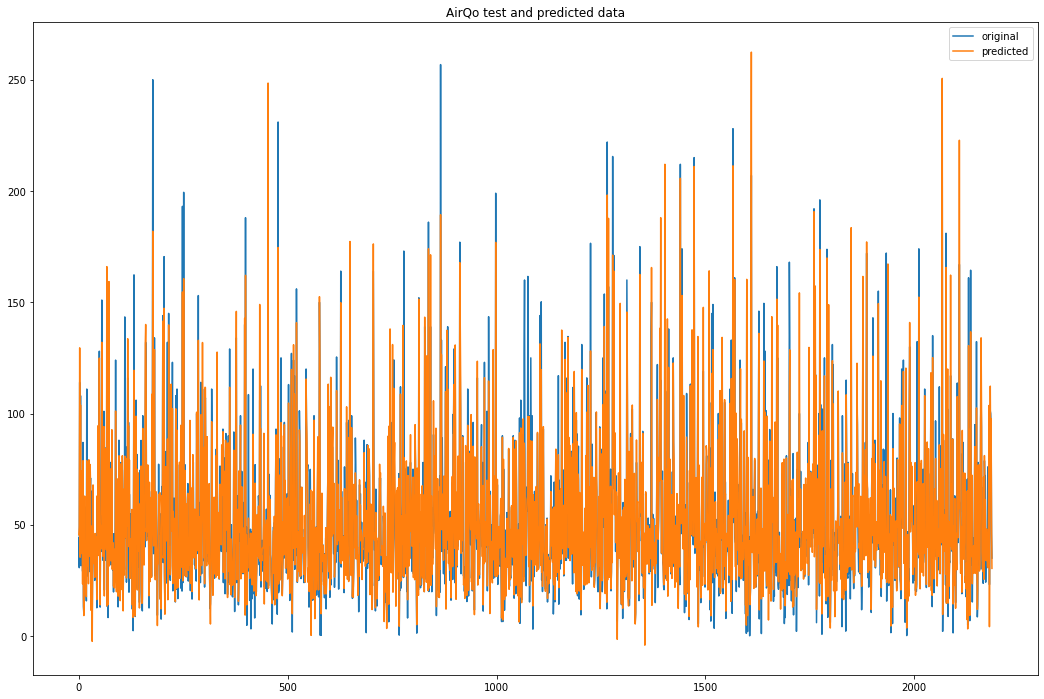

In [654]:
#prediction plot
x_ax = range(len(y_test))
plt.figure(figsize=(18,12))
plt.plot(x_ax, y_test, label="original")
plt.plot(x_ax, ypred, label="predicted")
plt.title("AirQo test and predicted data")
plt.legend()
plt.show()

In [655]:
#train all train set
xgbr.fit(X,y)

[11:59:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=500,
             n_jobs=-1, nthread=None, objective='reg:linear', random_state=102,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

#### File Submission

In [656]:
set(test.ID == ss.ID)

{True}

In [657]:
xgbr_prediction = np.round(xgbr.predict(test_new),1)

In [658]:
xgbr_prediction

array([ 39.9,  39.9,  46.4, ...,  38.3, 229. , 101.9], dtype=float32)

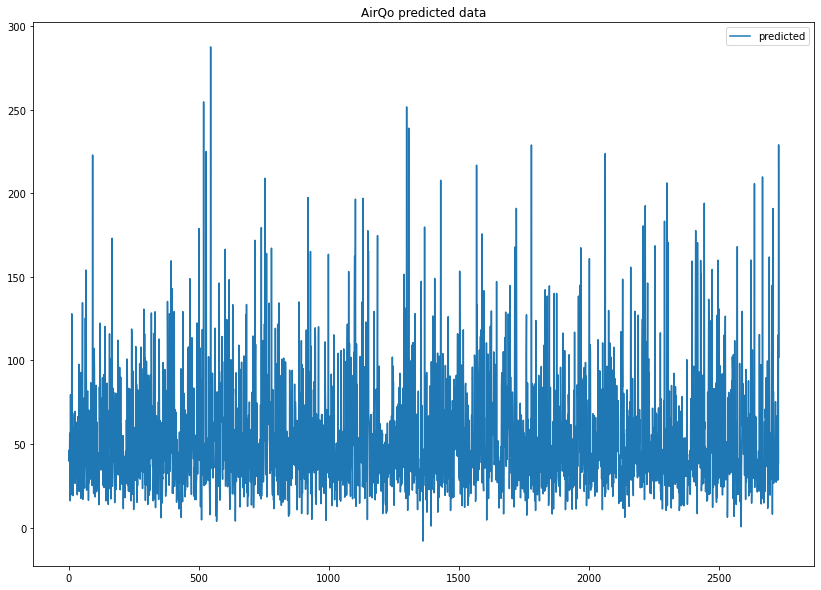

In [659]:
#prediction plot
x_ax = range(len(xgbr_prediction))
plt.figure(figsize=(14, 10))
plt.plot(x_ax, xgbr_prediction, label="predicted")
plt.title("AirQo predicted data")
plt.legend()
plt.show()

In [660]:
ss.head()

,ID,ref_pm2_5
0,ID_00OZLF7X,NaN
1,ID_00ZI0D98,NaN
2,ID_017GTLAU,NaN
3,ID_01IBM7T2,NaN
4,ID_01II27D4,NaN


In [661]:
sub_file = ss.copy()

In [662]:
sub_file['Target'] = np.round_(xgbr_prediction,1)
sub_file.drop('ref_pm2_5',axis=1, inplace=True)
sub_file.head()

,ID,Target
0,ID_00OZLF7X,39.900002
1,ID_00ZI0D98,39.900002
2,ID_017GTLAU,46.400002
3,ID_01IBM7T2,40.200001
4,ID_01II27D4,56.500000


In [663]:
#sub_file.to_csv('xgbr_prediction10.csv',index=False)

### RandomForest

In [664]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(random_state=seed, n_estimators=1000, n_jobs=-1)

In [665]:
#fitting the model
rf.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=1000, n_jobs=-1, oob_score=False,
                      random_state=102, verbose=0, warm_start=False)

In [666]:
#prediction on training set
train_pred = np.round(rf.predict(X_train),1)

In [667]:
train_pred

array([92.6, 22.8, 48.6, ..., 30.8, 98.9, 44.9])

In [668]:
from sklearn.metrics import mean_squared_error as mse
import matplotlib.pyplot as plt

In [669]:
train_score = mse(y_train, train_pred, squared=False)
print("Training score: ", train_score) 

Training score:  5.282929021942867


In [670]:
#prediction on test set
ypred = np.round(rf.predict(X_test),1)
test_score = mse(y_test, ypred, squared=False)
print("Testing score: ", test_score)

Testing score:  13.187035693419325


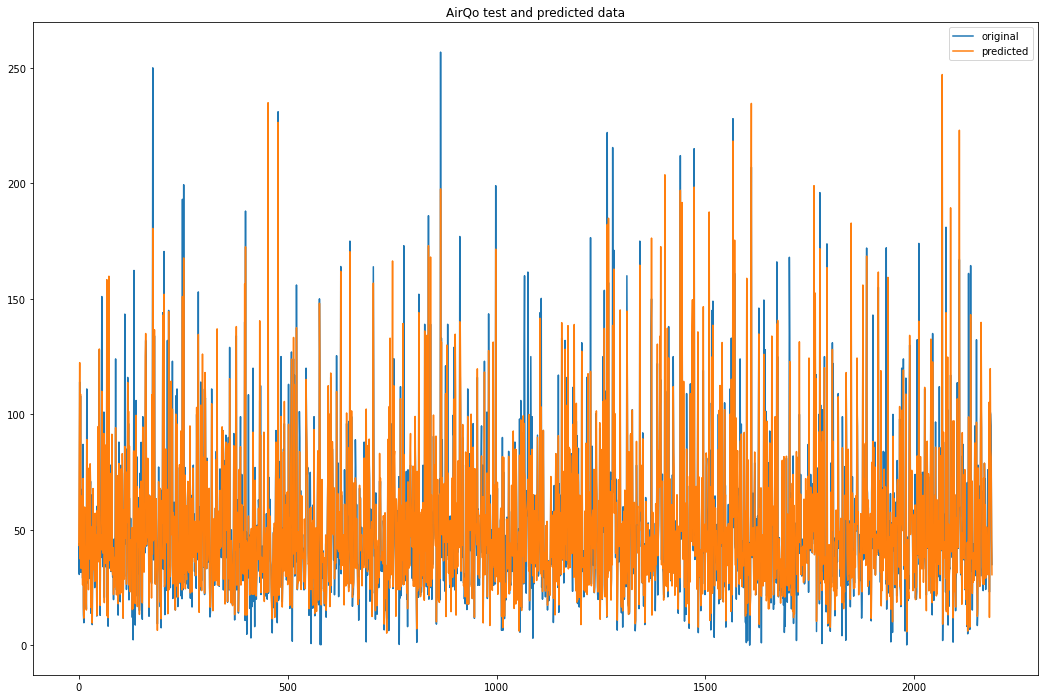

In [671]:
#prediction plot
x_ax = range(len(y_test))
plt.figure(figsize=(18,12))
plt.plot(x_ax, y_test, label="original")
plt.plot(x_ax, ypred, label="predicted")
plt.title("AirQo test and predicted data")
plt.legend()
plt.show()

In [672]:
#train all train set
rf.fit(X,y)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=1000, n_jobs=-1, oob_score=False,
                      random_state=102, verbose=0, warm_start=False)

#### File Submission

In [673]:
set(test.ID == ss.ID)

{True}

In [674]:
rf_prediction = np.round(rf.predict(test_new),1)

In [675]:
rf_prediction

array([ 41.5,  42.8,  46.7, ...,  36.3, 218.1, 103.1])

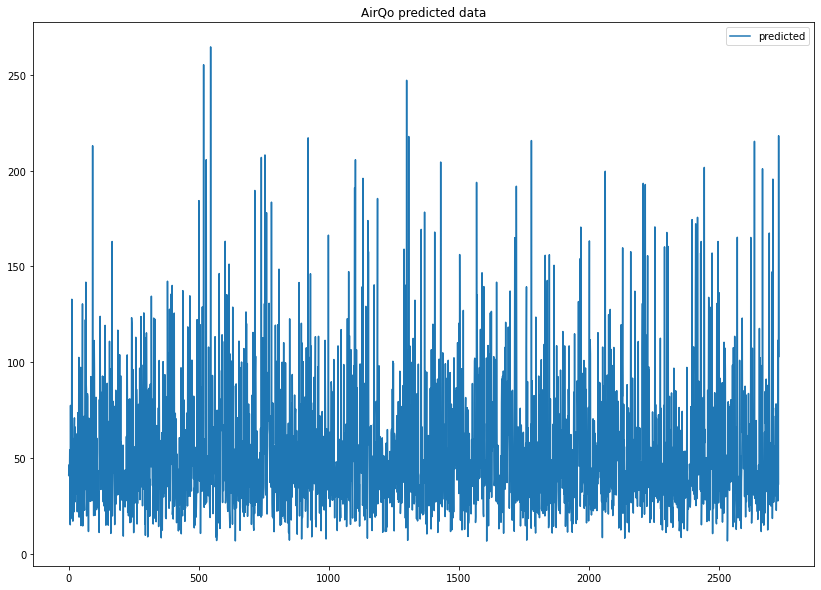

In [676]:
#prediction plot
x_ax = range(len(rf_prediction))
plt.figure(figsize=(14, 10))
plt.plot(x_ax, rf_prediction, label="predicted")
plt.title("AirQo predicted data")
plt.legend()
plt.show()

In [677]:
ss.head()

,ID,ref_pm2_5
0,ID_00OZLF7X,NaN
1,ID_00ZI0D98,NaN
2,ID_017GTLAU,NaN
3,ID_01IBM7T2,NaN
4,ID_01II27D4,NaN


In [678]:
sub_file = ss.copy()

In [679]:
sub_file['Target'] = np.round_(rf_prediction,1)
sub_file.drop('ref_pm2_5',axis=1, inplace=True)
sub_file.head()

,ID,Target
0,ID_00OZLF7X,41.5
1,ID_00ZI0D98,42.8
2,ID_017GTLAU,46.7
3,ID_01IBM7T2,40.6
4,ID_01II27D4,54.4


In [680]:
#sub_file.to_csv('rf_prediction2.csv',index=False)

#### File Submission

In [681]:
set(test.ID == ss.ID)

{True}

In [682]:
xgbr_prediction = np.round(xgbr.predict(test_new),1)

In [683]:
xgbr_prediction

array([ 39.9,  39.9,  46.4, ...,  38.3, 229. , 101.9], dtype=float32)

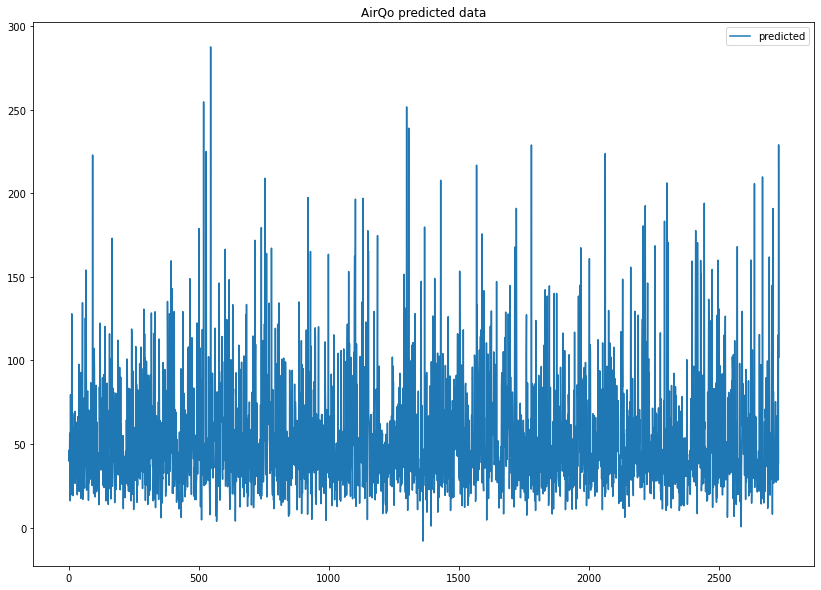

In [684]:
#prediction plot
x_ax = range(len(xgbr_prediction))
plt.figure(figsize=(14, 10))
plt.plot(x_ax, xgbr_prediction, label="predicted")
plt.title("AirQo predicted data")
plt.legend()
plt.show()

In [685]:
ss.head()

,ID,ref_pm2_5
0,ID_00OZLF7X,NaN
1,ID_00ZI0D98,NaN
2,ID_017GTLAU,NaN
3,ID_01IBM7T2,NaN
4,ID_01II27D4,NaN


In [686]:
sub_file = ss.copy()

In [687]:
sub_file['Target'] = np.round_(xgbr_prediction,1)
sub_file.drop('ref_pm2_5',axis=1, inplace=True)
sub_file.head()

,ID,Target
0,ID_00OZLF7X,39.900002
1,ID_00ZI0D98,39.900002
2,ID_017GTLAU,46.400002
3,ID_01IBM7T2,40.200001
4,ID_01II27D4,56.500000


In [688]:
sub_file.to_csv('xgbr_prediction9.csv',index=False)

### CATBOOST

In [689]:
pip install catboost

In [690]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

In [691]:
from catboost import CatBoostRegressor
cbr=CatBoostRegressor(od_type='Iter', random_seed=seed)

In [692]:
#from catboost import CatBoostRegressor
#cbr = make_pipeline(StandardScaler(), CatBoostRegressor())
#cbr.fit(X_train,y_train)

In [693]:
#fitting the model
cbr.fit(X_train,y_train)

Learning rate set to 0.057416
0:	learn: 34.2361140	total: 3.89ms	remaining: 3.89s
1:	learn: 32.8687283	total: 7.17ms	remaining: 3.58s
2:	learn: 31.5838696	total: 10.4ms	remaining: 3.44s
3:	learn: 30.4177123	total: 13.5ms	remaining: 3.37s
4:	learn: 29.3503337	total: 16.7ms	remaining: 3.32s
5:	learn: 28.2976801	total: 19.7ms	remaining: 3.27s
6:	learn: 27.3296218	total: 22.8ms	remaining: 3.23s
7:	learn: 26.4559284	total: 25.8ms	remaining: 3.2s
8:	learn: 25.6172236	total: 28.8ms	remaining: 3.17s
9:	learn: 24.8629355	total: 31.2ms	remaining: 3.09s
10:	learn: 24.1350504	total: 34.2ms	remaining: 3.07s
11:	learn: 23.4897629	total: 37.3ms	remaining: 3.07s
12:	learn: 22.8819529	total: 40.3ms	remaining: 3.06s
13:	learn: 22.3117407	total: 43.5ms	remaining: 3.06s
14:	learn: 21.7745783	total: 46.6ms	remaining: 3.06s
15:	learn: 21.2999564	total: 49.8ms	remaining: 3.06s
16:	learn: 20.8256558	total: 52.8ms	remaining: 3.05s
17:	learn: 20.4218008	total: 55.8ms	remaining: 3.04s
18:	learn: 20.0580764	total

In [694]:
cbr.get_params(deep=True)

{'loss_function': 'RMSE', 'od_type': 'Iter', 'random_seed': 102}

In [695]:
#prediction on training set
train_pred = np.round(cbr.predict(X_train),1)

In [696]:
train_pred

array([ 89.3,  24.5,  47.9, ...,  32.8, 100.1,  46.1])

In [697]:
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import cross_val_score, KFold
import matplotlib.pyplot as plt

In [698]:
train_score = mse(y_train, train_pred, squared=False)
print("Training score: ", train_score) 

Training score:  7.460975890256678


In [699]:
#prediction on test set
ypred = np.round(cbr.predict(X_test),1)
test_score = mse(y_test, ypred, squared=False)
print("Testing score: ", test_score)

Testing score:  10.820592486780695


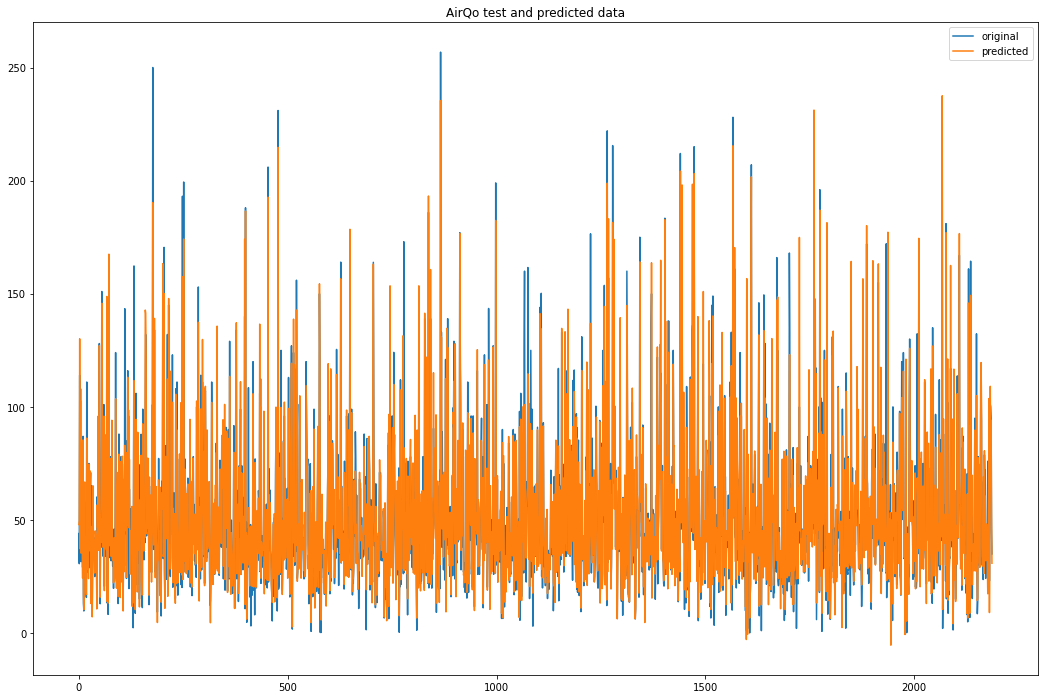

In [700]:
#prediction plot
x_ax = range(len(y_test))
plt.figure(figsize=(18,12))
plt.plot(x_ax, y_test, label="original")
plt.plot(x_ax, ypred, label="predicted")
plt.title("AirQo test and predicted data")
plt.legend()
plt.show()

In [701]:
#train all train set
cbr.fit(X,y)

Learning rate set to 0.059743
0:	learn: 34.1111339	total: 13.6ms	remaining: 13.6s
1:	learn: 32.7152372	total: 18.8ms	remaining: 9.37s
2:	learn: 31.4127085	total: 23.9ms	remaining: 7.93s
3:	learn: 30.2093543	total: 29.4ms	remaining: 7.32s
4:	learn: 29.0876592	total: 34.7ms	remaining: 6.9s
5:	learn: 28.0000220	total: 39.6ms	remaining: 6.55s
6:	learn: 27.0022003	total: 44.6ms	remaining: 6.32s
7:	learn: 26.0825499	total: 49.6ms	remaining: 6.15s
8:	learn: 25.2383821	total: 54.5ms	remaining: 6s
9:	learn: 24.4192716	total: 59ms	remaining: 5.84s
10:	learn: 23.7032911	total: 63.9ms	remaining: 5.75s
11:	learn: 23.0350246	total: 69ms	remaining: 5.68s
12:	learn: 22.4376158	total: 74.3ms	remaining: 5.64s
13:	learn: 21.8322782	total: 79.2ms	remaining: 5.57s
14:	learn: 21.2754148	total: 84.3ms	remaining: 5.53s
15:	learn: 20.7829850	total: 89.6ms	remaining: 5.51s
16:	learn: 20.3083464	total: 95.1ms	remaining: 5.5s
17:	learn: 19.8767943	total: 99.8ms	remaining: 5.44s
18:	learn: 19.5060926	total: 105ms	

In [702]:
from sklearn.model_selection import cross_val_score

In [703]:
cv = cross_val_score(cbr, X, y, cv=10)
cv_test_score = cbr.fit(X, y).score(X, y)
print('CV accuracy score: %0.3f' % np.mean(cv))
print('Test accuracy score: %0.3f' % (cv_test_score))

Streaming output truncated to the last 5000 lines.
6:	learn: 27.3670488	total: 23.1ms	remaining: 3.28s
7:	learn: 26.4630821	total: 26.4ms	remaining: 3.27s
8:	learn: 25.6221687	total: 29.7ms	remaining: 3.27s
9:	learn: 24.8120768	total: 33.1ms	remaining: 3.28s
10:	learn: 24.1069730	total: 36.4ms	remaining: 3.27s
11:	learn: 23.3998549	total: 39.6ms	remaining: 3.26s
12:	learn: 22.7959690	total: 42.9ms	remaining: 3.26s
13:	learn: 22.2043966	total: 46.5ms	remaining: 3.27s
14:	learn: 21.6658609	total: 49.8ms	remaining: 3.27s
15:	learn: 21.1780289	total: 53.3ms	remaining: 3.28s
16:	learn: 20.7900475	total: 55.5ms	remaining: 3.21s
17:	learn: 20.3722306	total: 59.2ms	remaining: 3.23s
18:	learn: 19.9866509	total: 62.5ms	remaining: 3.23s
19:	learn: 19.6217866	total: 65.7ms	remaining: 3.22s
20:	learn: 19.2828405	total: 69ms	remaining: 3.22s
21:	learn: 18.9674488	total: 72.5ms	remaining: 3.22s
22:	learn: 18.6870536	total: 75.8ms	remaining: 3.22s
23:	learn: 18.4379284	total: 79ms	remaining: 3.21s
24:

#### File Submission

In [704]:
set(test.ID == ss.ID)

{True}

In [705]:
cbr_prediction = np.round(cbr.predict(test_new),1)

In [706]:
cbr_prediction

array([ 41.8,  41.3,  46.2, ...,  37. , 230.4, 105.9])

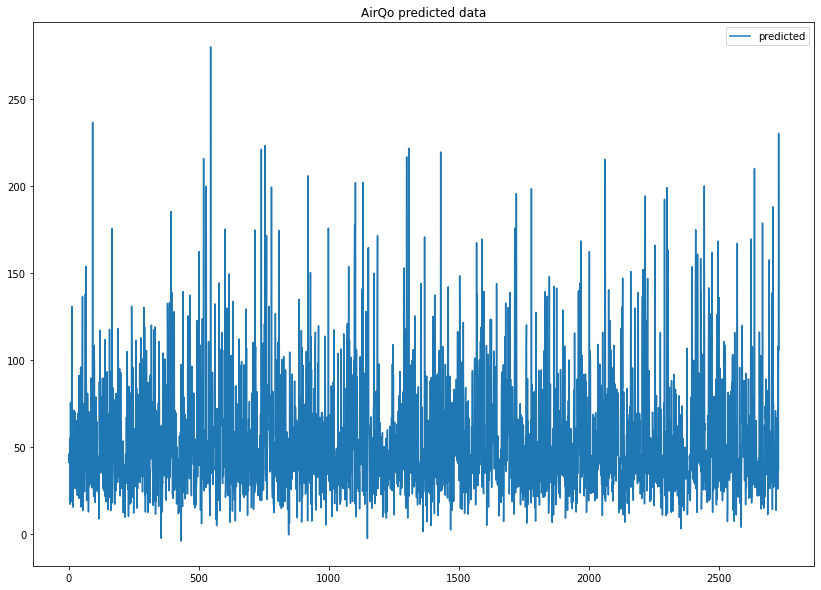

In [707]:
#prediction plot
x_ax = range(len(cbr_prediction))
plt.figure(figsize=(14, 10))
plt.plot(x_ax, cbr_prediction, label="predicted")
plt.title("AirQo predicted data")
plt.legend()
plt.show()

In [708]:
ss.head()

,ID,ref_pm2_5
0,ID_00OZLF7X,NaN
1,ID_00ZI0D98,NaN
2,ID_017GTLAU,NaN
3,ID_01IBM7T2,NaN
4,ID_01II27D4,NaN


In [709]:
sub_file = ss.copy()

In [710]:
sub_file['Target'] = np.round_(cbr_prediction,1)
sub_file.drop('ref_pm2_5',axis=1, inplace=True)
sub_file.head()

,ID,Target
0,ID_00OZLF7X,41.8
1,ID_00ZI0D98,41.3
2,ID_017GTLAU,46.2
3,ID_01IBM7T2,41.5
4,ID_01II27D4,55.0


In [711]:
#sub_file.to_csv('cbr_prediction6.csv',index=False)

## Neural Network

In [712]:
from sklearn.neural_network import MLPRegressor

In [713]:
mlp = MLPRegressor(hidden_layer_sizes=(30,20,10),
activation='relu',
solver='adam',
shuffle=True,
tol=1e-5,
random_state=seed,
max_iter=1000)
mlp.fit(X_train,y_train)

MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(30, 20, 10), learning_rate='constant',
             learning_rate_init=0.001, max_fun=15000, max_iter=1000,
             momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
             power_t=0.5, random_state=102, shuffle=True, solver='adam',
             tol=1e-05, validation_fraction=0.1, verbose=False,
             warm_start=False)

In [714]:
#mlp.get_params(deep=True)

In [715]:
#prediction on training set
train_pred = np.round(mlp.predict(X_train),1)

In [716]:
train_pred

array([80.5, 27.5, 51.8, ..., 34.2, 91. , 46. ])

In [717]:
from sklearn.metrics import mean_squared_error as mse
import matplotlib.pyplot as plt

In [718]:
train_score = mse(y_train, train_pred, squared=False)
print("Training score: ", train_score) 

Training score:  16.311615472230017


In [719]:
#prediction on test set
ypred = np.round(mlp.predict(X_test),1)
test_score = mse(y_test, ypred, squared=False)
print("Testing score: ", test_score)

Testing score:  16.06246508592278


In [720]:
from sklearn.model_selection import cross_val_score

In [721]:
cv = cross_val_score(mlp, X_train, y_train, cv=10)
cv_test_score = mlp.fit(X_train, y_train).score(X_train, y_train)
print('CV accuracy score: %0.3f' % np.mean(cv))
print('Test accuracy score: %0.3f' % (cv_test_score))

CV accuracy score: 0.773
Test accuracy score: 0.790


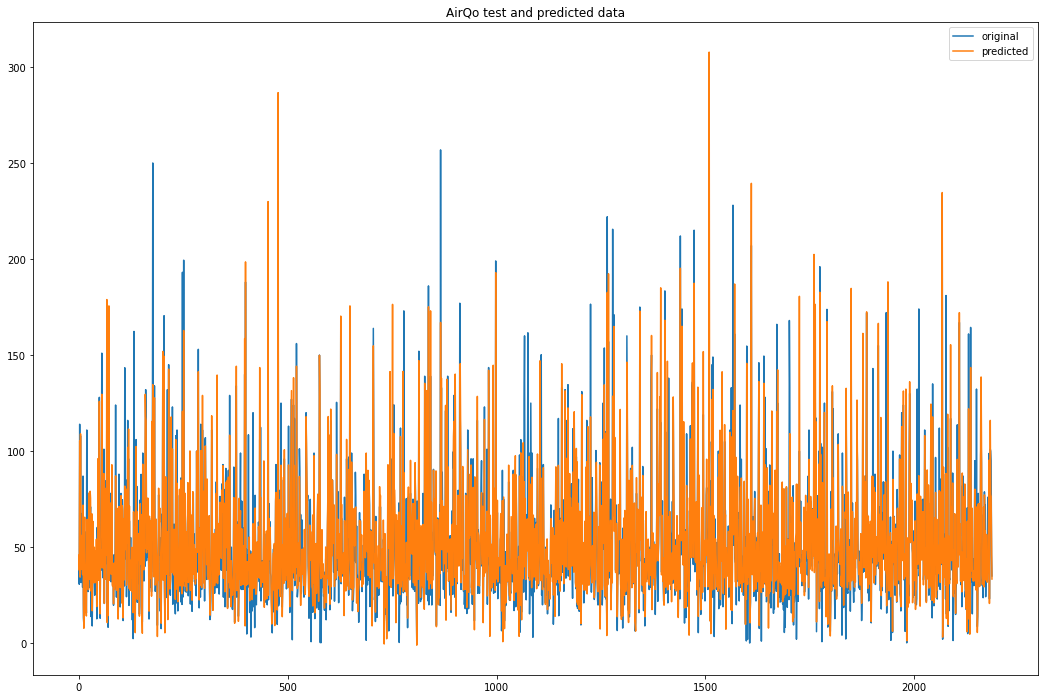

In [722]:
#prediction plot
x_ax = range(len(y_test))
plt.figure(figsize=(18,12))
plt.plot(x_ax, y_test, label="original")
plt.plot(x_ax, ypred, label="predicted")
plt.title("AirQo test and predicted data")
plt.legend()
plt.show()

In [723]:
#train all train set
mlp.fit(X,y)

MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(30, 20, 10), learning_rate='constant',
             learning_rate_init=0.001, max_fun=15000, max_iter=1000,
             momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
             power_t=0.5, random_state=102, shuffle=True, solver='adam',
             tol=1e-05, validation_fraction=0.1, verbose=False,
             warm_start=False)

#### File Submission

In [724]:
set(test.ID == ss.ID)

{True}

In [725]:
mlp_prediction = np.round(mlp.predict(test_new),1)

In [726]:
mlp_prediction

array([ 44.8,  43.9,  48.5, ...,  40.1, 216. , 100.9])

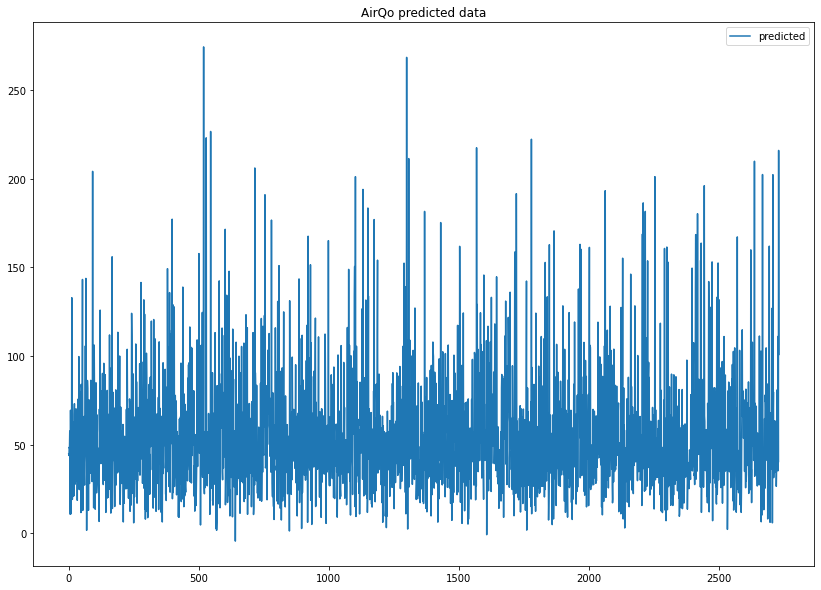

In [727]:
#prediction plot
x_ax = range(len(mlp_prediction))
plt.figure(figsize=(14, 10))
plt.plot(x_ax, mlp_prediction, label="predicted")
plt.title("AirQo predicted data")
plt.legend()
plt.show()

In [728]:
ss.head()

,ID,ref_pm2_5
0,ID_00OZLF7X,NaN
1,ID_00ZI0D98,NaN
2,ID_017GTLAU,NaN
3,ID_01IBM7T2,NaN
4,ID_01II27D4,NaN


In [729]:
sub_file = ss.copy()

In [730]:
sub_file['Target'] = np.round_(mlp_prediction,1)
sub_file.drop('ref_pm2_5',axis=1, inplace=True)
sub_file.head()

,ID,Target
0,ID_00OZLF7X,44.8
1,ID_00ZI0D98,43.9
2,ID_017GTLAU,48.5
3,ID_01IBM7T2,48.0
4,ID_01II27D4,57.7


In [731]:
#sub_file.to_csv('mlp_prediction4.csv',index=False)

## LightGBM

In [732]:
from lightgbm import LGBMRegressor
#from sklearn.ensemble import RandomForestRegressor

In [733]:
#rf = RandomForestRegressor(n_estimators=500, random_state=seed)
lgb = LGBMRegressor(n_estimators=1000, random_state=seed, boosting_type='dart', objective='regression')

In [734]:
lgb.get_params()

{'boosting_type': 'dart',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 1000,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': 'regression',
 'random_state': 102,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': True,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

In [735]:
# scaling the data
#from sklearn.preprocessing import StandardScaler
#scaler = StandardScaler()

# we fit the train data
#scaler.fit(X_train)

# scaling the train data
#X_train = scaler.transform(X_train)
#X_test = scaler.transform(X_test)

In [736]:
#fitting the model
lgb.fit(X_train,y_train)

LGBMRegressor(boosting_type='dart', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=1000, n_jobs=-1, num_leaves=31,
              objective='regression', random_state=102, reg_alpha=0.0,
              reg_lambda=0.0, silent=True, subsample=1.0,
              subsample_for_bin=200000, subsample_freq=0)

In [737]:
#prediction on training set
train_pred = np.round(lgb.predict(X_train),1)

In [738]:
train_pred

array([91.1, 23. , 49.2, ..., 32.9, 97.3, 43.4])

In [739]:
from sklearn.metrics import mean_squared_error as mse
import matplotlib.pyplot as plt

In [740]:
train_score = mse(y_train, train_pred, squared=False)
print("Training score: ", train_score) 

Training score:  7.399715816711886


In [741]:
#prediction on test set
ypred = np.round(lgb.predict(X_test),1)
test_score = mse(y_test, ypred, squared=False)
print("Testing score: ", test_score)

Testing score:  11.091993017452847


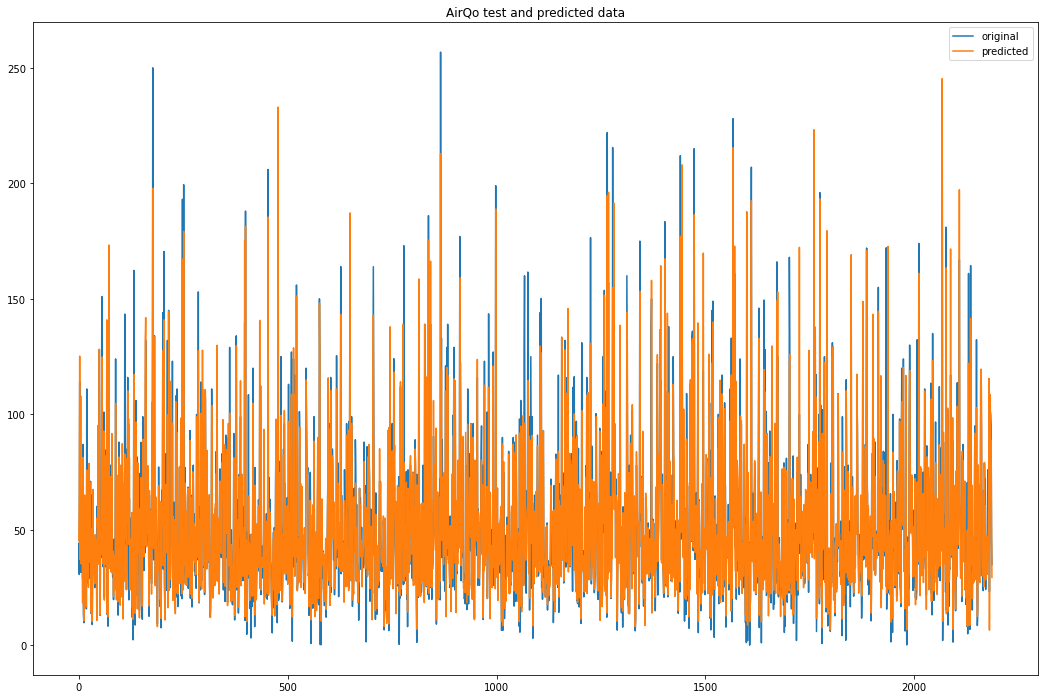

In [742]:
#prediction plot
x_ax = range(len(y_test))
plt.figure(figsize=(18,12))
plt.plot(x_ax, y_test, label="original")
plt.plot(x_ax, ypred, label="predicted")
plt.title("AirQo test and predicted data")
plt.legend()
plt.show()

In [743]:
#train all train set
lgb.fit(X,y)

LGBMRegressor(boosting_type='dart', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=1000, n_jobs=-1, num_leaves=31,
              objective='regression', random_state=102, reg_alpha=0.0,
              reg_lambda=0.0, silent=True, subsample=1.0,
              subsample_for_bin=200000, subsample_freq=0)

#### File Submission

In [744]:
set(test.ID == ss.ID)

{True}

In [745]:
lgb_prediction = np.round(lgb.predict(test_new),1)

In [746]:
lgb_prediction

array([ 39.8,  39.9,  45.4, ...,  35.8, 223.3, 104.3])

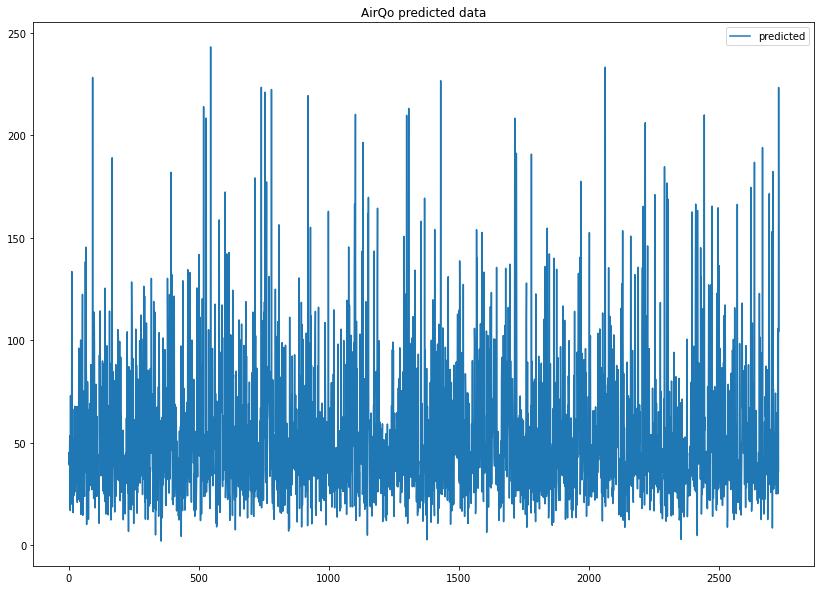

In [747]:
#prediction plot
x_ax = range(len(lgb_prediction))
plt.figure(figsize=(14, 10))
plt.plot(x_ax, lgb_prediction, label="predicted")
plt.title("AirQo predicted data")
plt.legend()
plt.show()

In [748]:
ss.head()

,ID,ref_pm2_5
0,ID_00OZLF7X,NaN
1,ID_00ZI0D98,NaN
2,ID_017GTLAU,NaN
3,ID_01IBM7T2,NaN
4,ID_01II27D4,NaN


In [749]:
sub_file = ss.copy()

In [750]:
sub_file['Target'] = np.round_(lgb_prediction,1)
sub_file.drop('ref_pm2_5',axis=1, inplace=True)
sub_file.head()

,ID,Target
0,ID_00OZLF7X,39.8
1,ID_00ZI0D98,39.9
2,ID_017GTLAU,45.4
3,ID_01IBM7T2,38.9
4,ID_01II27D4,53.4


In [751]:
#sub_file.to_csv('lgb_prediction2.csv',index=False)

#Stacking

In [752]:
#Validation function
n_folds = 5

def rmse_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=seed).get_n_splits(X_train.values)
    rmse= np.sqrt(-cross_val_score(model, X_train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

In [753]:
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)
        return self
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)


#fit() – This method clones all the base models which were passed as a parameter, and then
#        train the cloned models in the whole dataset.

#predict() – All the cloned models will predict and the predictions will be column stacked using “np.column_stack()”
#            then the average of that prediction will be calculated and returned.

In [755]:
averaged_models = AveragingModels(models = (mlp,rf,xgb,cbr,lgb,))
score = rmse_cv(averaged_models)
print(" Averaged base models score: {:.4f}n".format(score.mean()))

TypeError: ignored